In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 6
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Process"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| code-fold: true
#| output: false
#| code-summary: サブサンプリングなしの Zig-Zag 過程のシミュレーションをする関数 ZZ() を定義
using ZigZagBoomerang
using Distributions
using Random

λ(∇U, x, θ, F::ZigZag1d) = pos(θ*∇U(x)) # rate function on E
λ_bar(τ, a, b) = pos(a + b*τ)  # affine proxy

"""
`x`: current location, `θ`: current velocity, `t`: current time,
"""
function move_forward(τ, t, x, θ, ::ZigZag1d)
    τ + t, x + θ*τ , θ
end

"""
    `∇U`: gradient of the negative log-density
    `(x,θ)`: initial state
    `T`: Time Horizon    
    `a+bt`: computational bound for intensity m(t)

    `num`: ポアソン時刻に到着した回数
    `acc`: 受容回数．`acc/num` は acceptance rate
"""
function ZZ(∇U, x::Float64, θ::Float64, T::Float64, y, Flow::ZigZagBoomerang.ContinuousDynamics; rng=Random.GLOBAL_RNG, ab=ab_ZZ)
    t = zero(T)
    Ξ = [(t, x, θ)]
    num = acc = 0
    epoch_list = [num]
    a, b = ab(x, θ, Flow)
    t′ =  t + poisson_time(a, b, rand())  # イベントは a,b が定める affine proxy に従って生成する

    while t < T
        τ = t′ - t
        t, x, θ = move_forward(τ, t, x, θ, Flow)
        l, lb = λ(∇U, x, θ, Flow), λ_bar(τ, a, b)  # λ が真のレート, λ_bar が affine proxy
        num += 1
        if rand()*lb < l
            acc += 1
            if l > lb + 0.01
                println(l-lb)
            end
            θ = -θ
            push!(Ξ, (t, x, θ))
            push!(epoch_list, num)
        end
        a, b = ab(x, θ, Flow)
        t′ = t + poisson_time(a, b, rand())
    end

    return Ξ, epoch_list, acc/num
end

ZZ

In [3]:
#| output: false
#| code-fold: true
#| code-summary: 今回の設定に応じたレート関数 (a+bt)+ を用意
pos(x) = max(zero(x), x)  # positive part
a(x, θ, ρ, σ, y) = θ * x / ρ^2 + (θ/σ^2) * sum(x .- y)
b(x, θ, ρ, σ, y) = ρ^(-2) + length(y)/σ^2

ρ, σ, x0, θ0 = 1.0, 1.0, 1.0, 1.0
n1, n2 = 100, 10^4
TrueDistribution = Normal(x0, σ)
y1 = rand(TrueDistribution, n1)
y2 = rand(TrueDistribution, n2)

# computational bounds for intensity m(t)
ab_ZZ_n1(x, θ, ::ZigZag1d) = (a(x, θ, ρ, σ, y1), b(x, θ, ρ, σ, y1))
ab_ZZ_n2(x, θ, ::ZigZag1d) = (a(x, θ, ρ, σ, y2), b(x, θ, ρ, σ, y2))

∇U1(x) = x/ρ^2 + (length(y1)/σ^2) * (x - mean(y1)) 
∇U2(x) = x/ρ^2 + (length(y2)/σ^2) * (x - mean(y2)) 

# T = 2500.0
# trace_ZZ1, epochs_ZZ1, acc_ZZ1 = ZZ(∇U1, x0, θ0, T, ZigZag1d(); ab=ab_ZZ_n1)
# trace_ZZ2, num_ZZ2, acc_ZZ2 = ZZ(∇U2, x0, θ0, T, ZigZag1d(); ab=ab_ZZ_n2)
# dt = 0.01
# traj_ZZ1 = discretize(trace_ZZ1, ZigZag1d(), dt)
# traj_ZZ2 = discretize(trace_ZZ2, ZigZag1d(), dt)

∇U2 (generic function with 1 method)

In [4]:
#| output: false
#| code-fold: true
#| code-summary: N 回 ZZ() を実行して，その事後平均の MSE を計算する関数 experiment() を定義
function SquaredError(sample::Vector{Float64}, y)
    True_Posterior_Mean = sum(y) / (length(y) + 1)
    return (mean(sample) - True_Posterior_Mean)^2
end

"""
    epoch_list: 注目するエポック数のリスト
    N: 実験回数
"""
function experiment(epoch_list, T, dt, N, ∇U, x0, θ0, y, Sampler; ab=ab_ZZ_n1)
    SE_sum = zero(epoch_list)
    acc_list = []
    for _ in 1:N
        trace_ZZ1, epochs_ZZ1, acc_ZZ1 = Sampler(∇U, x0, θ0, T, y, ZigZag1d(); ab=ab)
        push!(acc_list, acc_ZZ1)
        traj_ZZ1 = discretize(trace_ZZ1, ZigZag1d(), dt)
        SE_list = []
        for T in epoch_list
            epoch = findfirst(x -> x > T, epochs_ZZ1) - 1
            t = findfirst(x -> x > trace_ZZ1[epoch][1], traj_ZZ1.t) - 1
            SE = SquaredError(traj_ZZ1.x[1:t], y)
            push!(SE_list, SE)
        end
        SE_sum += SE_list
    end
    return SE_sum ./ N, mean(acc_list)
end

experiment

In [5]:
#| code-fold: true
#| code-summary: 実験の実行
using Plots

T = 3000.0
epoch_list = [10.0, 100.0, 1000.0, 10000.0]
dt = 0.01
N = 10

MSE_ZZ1, acc = experiment(epoch_list, T, dt, N, ∇U1, x0, θ0, y1, ZZ; ab=ab_ZZ_n1)
p = plot(#epoch_list, MSE_ZZ1,
    xscale=:log10,
    yscale=:log10,
    )
scatter!(p, epoch_list, MSE_ZZ1,
    marker=:circle,
    markersize=5,
    markeralpha=0.6,
    color="#78C2AD",
    label=nothing
    )

using GLM, DataFrames
df = DataFrame(X = log10.(epoch_list), Y = log10.(MSE_ZZ1))
model = lm(@formula(Y ~ X), df)
X_pred = range(minimum(df.X), maximum(df.X), length=100)
Y_pred = predict(model, DataFrame(X = X_pred))
plot!(p, 10 .^ X_pred, 10 .^ Y_pred,
    line=:solid,
    linewidth=2,
    color="#78C2AD",
    label="ZZ"
    )

# display(p)

println("Average acceptance rate: $acc")

Average acceptance rate: 1.0


In [6]:
#| code-fold: true
#| code-summary: ZZ-SS (ZigZag with Subsampling) の定義
#| output: false

λj(j,x,θ,y) = pos(θ * (x/ρ^2 + length(y)/σ^2 * (x - y[j])))

function ZZ_SS(∇U, x::Float64, θ::Float64, T::Float64, y, Flow::ZigZagBoomerang.ContinuousDynamics; rng=Random.GLOBAL_RNG, ab=ab_ZZ)
    t = zero(T)
    Ξ = [(t, x, θ)]
    num = acc = 0
    epoch_list = [num]
    a, b = ab(x, θ, Flow)
    t′ =  t + poisson_time(a, b, rand())  # イベントは a,b が定める affine proxy に従って生成する

    while t < T
        τ = t′ - t
        t, x, θ = move_forward(τ, t, x, θ, Flow)
        j = rand(1:length(y))
        l, lb = λj(j, x, θ, y), λ_bar(τ, a, b)  # λ が真のレート, λ_bar が affine proxy
        num += 1
        if rand()*lb < l
            acc += 1
            if l > lb + 0.01
                println(l-lb)
            end
            θ = -θ
            push!(Ξ, (t, x, θ))
            push!(epoch_list, num)
        end
        a, b = ab(x, θ, Flow)
        t′ = t + poisson_time(a, b, rand())
    end

    return Ξ, epoch_list, acc/num
end

ZZ_SS (generic function with 1 method)

In [7]:
#| code-fold: true
#| code-summary: 実験の実行
MSE_ZZ_SS, acc = experiment(epoch_list, T, dt, N, ∇U1, x0, θ0, y1, ZZ_SS; ab=ab_ZZ_n1)
println("Average acceptance rate: $acc")

290.9232596987785
33.93482396039691
39.564697674543396
52.137540668078714
99.16839005735292
40.30609543177962
180.135418209445
3.192290346623466
30.13276439119208
40.30609543177961
94.58616938856821
127.085468218764
37.30995714963767
44.895724715417934
33.93482396039691
13.70065621438787
127.085468218764
59.26187184458112
94.58616938856821
8.422760735010765
39.590408133339366
5.607893244525263
177.26891267291717
98.01125563740183
241.4658185100631
29.84901453815403
20.16234129675203
5.6078932445252665
115.55282845915399
12.089482326109053
52.38660532312515
23.545183454111083
123.44135969283857
98.01125563740183
69.10375428801271
185.68184598141045
147.10360918359137
12.320201599237958
77.37783817422543
3.536292607173781
27.224491843685335
37.309957149637654
69.10375428801271
135.02510696025314
38.61695450946013
202.41033491703715
290.92325969877857
49.73484512872497
6.965010096607665
94.58616938856821
127.085468218764
24.6893644972009
28.951141456717945
44.53220141267446
111.6475541212

42.60030081249495
266.53234947937676
42.60030081249495
29.87283741501963
41.47363169378564
2.391284355878817
30.679452851852453
39.547116753607156
31.05510185604965
12.32020159923795
149.7775991804009
49.30894741805631
59.10074463180854
135.0251069602531
12.110253776199956
52.137540668078714
111.8062921470721
8.358851999532519
52.38660532312515
88.88030895229339
135.0251069602531
147.10360918359135
78.30089276736814
158.07377683348614
181.57291373868003
99.1683900573529
181.57291373868006
24.689364497200895
39.547116753607156
99.16839005735291
37.30995714963765
147.10360918359137
12.089482326109051
241.46581851006306
8.422760735010765
19.593334134037743
37.30995714963765
39.564697674543396
111.64755412128298
38.8932187457421
266.5323494793767
185.97099126216264
102.03353509675753
29.849014538154034
135.02510696025314
29.350438176131988
185.68184598141045
147.10360918359135
88.8803089522934
177.26891267291717
181.57291373868006
19.59333413403774
169.7651739368786
13.700656214387866
201.

127.08546821876402
106.09445232540486
78.30089276736815
89.63233490391934
81.40617756413937
241.4658185100631
12.911814557979968
44.895724715417934
81.40617756413937
77.37783817422543
91.86553060526546
59.10074463180854
12.320201599237947
98.0659947060156
111.80629214707211
169.76517393687863
20.162341296752025
148.64611672470443
77.37783817422543
34.196791495136345
57.84462279888789
3.192290346623466
10.17999000411513
49.30894741805632
44.53220141267447
12.911814557979964
37.456049956587044
99.16839005735292
78.30089276736815
38.61695450946014
41.62716321059066
89.63233490391933
6.0683324385272925
8.422760735010765
158.07377683348614
201.06928947942075
177.26891267291717
28.95114145671794
52.38660532312516
2.3912843558788133
31.05510185604965
127.08546821876402
98.0659947060156
12.089482326109055
158.07377683348614
54.762768061042436
69.10375428801271
54.76276806104243
39.564697674543396
34.19679149513635
39.564697674543396
40.30609543177961
10.179990004115135
29.849014538154037
147.1

57.84462279888789
148.64611672470443
30.13276439119208
23.545183454111083
39.59040813333935
29.84901453815403
180.135418209445
42.60030081249495
10.17999000411514
41.62716321059065
20.162341296752032
81.7336967566978
77.37783817422545
29.849014538154037
44.53220141267446
58.37744034812503
38.616954509460136
201.06928947942075
102.03353509675752
33.93482396039691
177.26891267291717
6.068332438527296
266.53234947937676
185.97099126216264
158.07377683348614
148.64611672470443
120.89564677431532
54.762768061042436
176.36096045667495
34.19679149513635
121.03724018706123
41.627163210590666
158.07377683348614
59.26187184458112
20.162341296752025
29.87283741501963
20.162341296752025
185.68184598141048
12.110253776199958
78.30089276736817
176.36096045667495
290.9232596987785
89.63233490391934
33.93482396039691
177.26891267291717
39.547116753607156
89.63233490391933
52.13754066807871
149.77759918040087
3.5362926071737775
12.110253776199958
81.7336967566978
59.548951207002204
52.137540668078714
5

81.7336967566978
106.09445232540486
148.64611672470443
31.055101856049653
98.01125563740183
176.36096045667495
135.02510696025314
13.70065621438787
202.41033491703718
31.05510185604965
12.32020159923794
149.77759918040087
185.97099126216264
37.309957149637654
89.63233490391933
8.358851999532519
148.64611672470443
3.5362926071737775
177.26891267291717
41.62716321059065
10.179990004115128
122.26142393697279
59.10074463180854
111.64755412128298
69.10375428801271
101.6515022309354
38.61695450946014
122.26142393697279
89.63233490391931
12.320201599237954
39.59040813333935
2.391284355878817
12.110253776199958
62.26518473330445
69.10375428801271
12.089482326109042
30.679452851852453
28.95114145671794
149.77759918040087
29.87283741501963
52.38660532312515
62.26518473330446
19.59333413403774
23.545183454111083
12.110253776199961
34.19679149513635
77.37783817422543
98.0659947060156
35.65874028935221
62.26518473330446
158.07377683348614
19.593334134037743
98.01125563740183
149.77759918040087
4.59

44.89572471541793
181.57291373868006
27.224491843685342
6.965010096607665
176.36096045667495
3.1922903466234622
27.22449184368534
26.138036899152116
94.58616938856821
49.30894741805632
39.564697674543396
185.68184598141045
31.05510185604965
8.422760735010764
39.564697674543396
185.97099126216264
52.38660532312515
37.309957149637654
177.26891267291717
6.0683324385272925
30.679452851852453
148.64611672470443
111.8062921470721
59.261871844581115
94.58616938856818
98.01125563740183
32.193148978545864
38.8932187457421
12.110253776199961
181.57291373868006
102.03353509675752
41.62716321059065
126.69746769378338
28.93205309421429
3.5362926071737775
99.16839005735292
122.26142393697278
266.53234947937676
12.911814557979968
41.473631693785634
42.60030081249495
31.05510185604965
4.593105928248892
19.593334134037747
38.893218745742104
44.53220141267447
12.089482326109042
158.07377683348614
4.593105928248892
158.07377683348614
26.138036899152112
37.45604995658705
177.26891267291717
26.138036899152

27.22449184368534
29.849014538154034
13.700656214387868
3.536292607173781
176.36096045667495
62.265184733304466
24.689364497200895
3.536292607173781
59.10074463180854
78.30089276736815
52.38660532312515
111.64755412128298
39.564697674543396
111.64755412128301
89.63233490391933
33.93482396039691
77.37783817422543
62.26518473330446
30.679452851852446
122.26142393697279
177.26891267291717
111.64755412128301
99.16839005735292
12.911814557979962
20.162341296752032
6.965010096607664
106.09445232540486
37.309957149637654
35.65874028935221
49.30894741805632
176.36096045667495
6.068332438527294
59.26187184458112
44.53220141267447
81.73369675669778
59.10074463180854
59.548951207002204
81.7336967566978
176.36096045667495
8.422760735010762
57.84462279888789
169.76517393687863
176.36096045667495
78.30089276736817
41.473631693785634
37.456049956587044
158.07377683348614
88.8803089522934
176.36096045667495
122.26142393697279
102.03353509675752
29.84901453815403
177.26891267291717
52.137540668078714
1

44.89572471541794
6.965010096607664
77.37783817422545
12.911814557979962
147.10360918359135
127.08546821876402
42.60030081249496
106.09445232540486
39.54711675360717
147.10360918359135
135.02510696025314
69.10375428801271
38.8932187457421
35.65874028935221
148.64611672470443
52.38660532312515
40.30609543177961
121.03724018706123
98.01125563740183
102.03353509675752
127.08546821876402
180.135418209445
98.01125563740183
24.6893644972009
6.965010096607664
41.473631693785634
12.911814557979968
41.473631693785634
6.965010096607664
106.09445232540486
42.60030081249495
102.0335350967575
37.456049956587044
89.63233490391934
98.01125563740183
59.54895120700221
33.93482396039691
24.6893644972009
12.089482326109046
35.65874028935221
135.02510696025314
77.37783817422543
28.951141456717945
39.59040813333935
33.93482396039691
176.36096045667495
201.06928947942075
147.10360918359135
28.951141456717945
27.224491843685342
111.64755412128301
52.38660532312516
34.196791495136345
10.179990004115133
12.911

290.9232596987785
29.350438176131988
62.265184733304466
12.110253776199961
290.9232596987785
35.6587402893522
28.951141456717945
94.58616938856821
54.762768061042436
44.895724715417934
54.762768061042436
49.73484512872497
81.40617756413937
24.68936449720089
185.68184598141045
32.193148978545864
34.19679149513635
115.55282845915397
8.358851999532515
31.055101856049646
6.965010096607667
12.110253776199958
49.30894741805632
77.37783817422545
54.762768061042436
147.10360918359135
8.358851999532519
40.30609543177961
38.61695450946014
3.536292607173774
89.63233490391934
98.0659947060156
147.10360918359135
88.8803089522934
126.69746769378338
2.3912843558788133
41.473631693785634
8.358851999532519
241.46581851006303
3.536292607173781
126.69746769378338
101.6515022309354
24.689364497200895
78.30089276736815
69.10375428801271
29.849014538154037
27.224491843685335
111.64755412128301
115.55282845915397
89.63233490391933
8.358851999532515
89.63233490391933
41.62716321059066
19.593334134037743
41.62

30.132764391192076
23.545183454111083
101.6515022309354
106.09445232540486
202.41033491703718
180.135418209445
58.377440348125035
32.193148978545864
49.30894741805631
44.53220141267447
88.8803089522934
6.965010096607664
266.53234947937676
185.97099126216264
176.36096045667495
54.762768061042436
10.179990004115137
16.32776379098888
28.95114145671795
39.564697674543396
12.089482326109055
12.32020159923795
32.193148978545864
12.320201599237954
35.65874028935221
8.358851999532522
89.63233490391933
185.97099126216264
266.53234947937676
111.64755412128298
30.679452851852446
54.762768061042436
29.35043817613198
26.138036899152116
42.60030081249495
30.132764391192083
34.19679149513635
38.61695450946014
41.62716321059066
12.110253776199968
169.76517393687863
35.65874028935221
135.02510696025314
24.68936449720089
52.137540668078714
99.16839005735291
8.422760735010762
266.53234947937676
16.32776379098888
19.593334134037747
185.68184598141045
121.03724018706123
26.138036899152116
123.4413596928385

35.65874028935221
49.73484512872498
42.60030081249495
94.58616938856818
29.849014538154037
98.01125563740183
30.13276439119208
148.64611672470443
35.65874028935221
12.320201599237953
24.68936449720089
34.19679149513635
30.67945285185245
54.76276806104243
106.09445232540486
40.30609543177961
35.65874028935221
4.593105928248889
180.135418209445
98.01125563740183
38.893218745742104
30.679452851852446
185.68184598141045
30.13276439119208
58.37744034812503
2.391284355878817
147.10360918359135
78.30089276736817
115.55282845915397
88.8803089522934
180.135418209445
26.138036899152116
29.350438176131984
34.19679149513635
123.44135969283857
127.08546821876402
30.679452851852446
111.64755412128298
94.58616938856821
91.86553060526546
111.80629214707213
23.545183454111076
29.350438176131988
54.76276806104243
20.162341296752032
77.37783817422543
23.545183454111076
115.55282845915397
49.30894741805632
44.53220141267447
135.02510696025314
77.37783817422543
2.3912843558788133
32.19314897854586
181.5729

44.895724715417934
122.26142393697279
44.895724715417934
148.64611672470443
26.138036899152116
27.22449184368534
169.76517393687863
41.47363169378564
62.265184733304466
266.53234947937676
81.40617756413937
59.548951207002204
38.893218745742104
12.110253776199956
185.68184598141048
121.03724018706123
28.951141456717945
39.59040813333935
6.0683324385273
120.89564677431531
148.64611672470443
147.10360918359135
81.40617756413937
122.26142393697279
99.16839005735291
62.265184733304466
147.10360918359135
26.13803689915212
30.679452851852453
122.26142393697279
24.68936449720089
8.358851999532515
38.61695450946014
12.911814557979966
13.700656214387871
169.76517393687863
35.65874028935221
62.265184733304466
149.77759918040087
88.8803089522934
158.07377683348614
3.536292607173781
29.35043817613198
26.138036899152116
39.5646976745434
111.64755412128301
44.89572471541794
4.593105928248892
177.26891267291717
169.7651739368786
89.63233490391933
37.309957149637654
13.70065621438787
58.377440348125035

30.13276439119207
41.627163210590666
123.44135969283857
81.40617756413937
120.89564677431531
28.95114145671794
20.162341296752025
185.97099126216264
147.10360918359135
91.86553060526546
30.679452851852453
54.762768061042436
121.03724018706123
202.41033491703718
266.53234947937676
33.93482396039691
29.350438176131988
201.06928947942075
126.69746769378338
98.01125563740183
6.068332438527291
24.689364497200895
122.26142393697279
30.13276439119207
38.893218745742104
106.09445232540486
29.872837415019625
27.22449184368534
8.422760735010765
121.03724018706123
54.762768061042436
49.73484512872498
4.593105928248889
41.473631693785634
58.37744034812503
106.09445232540486
33.93482396039691
123.44135969283857
202.41033491703718
12.11025377619996
39.54711675360716
52.38660532312515
42.60030081249494
20.162341296752032
12.911814557979966
111.80629214707211
23.545183454111083
126.69746769378338
185.68184598141045
44.89572471541793
29.872837415019628
77.37783817422543
12.911814557979966
181.572913738

2.3912843558788133
24.689364497200895
40.3060954317796
177.26891267291717
54.762768061042436
41.473631693785634
4.593105928248896
120.89564677431531
62.26518473330446
147.10360918359135
8.422760735010764
121.03724018706123
62.26518473330446
30.67945285185245
12.911814557979966
59.54895120700221
122.26142393697278
158.07377683348614
41.62716321059065
78.30089276736815
38.616954509460136
3.5362926071737792
44.89572471541794
181.57291373868006
24.689364497200895
169.76517393687863
39.59040813333936
58.377440348125035
120.89564677431531
98.06599470601563
29.84901453815403
266.53234947937676
148.64611672470443
30.679452851852446
58.377440348125035
77.37783817422545
290.9232596987785
27.22449184368534
78.30089276736815
12.110253776199956
28.95114145671795
32.19314897854586
29.84901453815403
37.45604995658705
12.110253776199958
59.26187184458112
31.055101856049646
5.607893244525265
32.193148978545864
49.30894741805632
111.80629214707211
5.607893244525268
177.26891267291717
40.30609543177962
7

27.224491843685342
8.422760735010765
12.110253776199956
122.26142393697279
123.44135969283857
58.377440348125035
158.07377683348614
28.932053094214297
147.10360918359135
8.422760735010765
121.03724018706123
37.45604995658705
24.68936449720089
185.97099126216264
39.564697674543396
34.19679149513635
111.64755412128301
176.36096045667495
12.089482326109055
201.06928947942075
12.110253776199968
23.54518345411108
49.73484512872497
185.68184598141048
176.36096045667495
81.40617756413937
115.552828459154
135.02510696025314
266.53234947937676
38.893218745742104
88.8803089522934
121.03724018706123
185.97099126216264
35.86824041674268
23.545183454111076
38.61695450946014
28.932053094214293
2.3912843558788097
177.26891267291717
98.01125563740183
106.09445232540486
28.95114145671794
57.84462279888788
202.41033491703718
241.46581851006303
81.40617756413937
12.110253776199961
28.951141456717945
30.132764391192076
34.19679149513635
27.224491843685335
42.60030081249495
99.16839005735291
12.08948232610

2.3912843558788115
77.37783817422543
12.089482326109051
39.5646976745434
29.849014538154034
180.135418209445
37.45604995658705
98.0659947060156
41.473631693785634
122.26142393697279
31.055101856049653
111.64755412128298
31.055101856049653
54.76276806104243
177.26891267291717
12.320201599237954
38.61695450946014
127.08546821876402
77.37783817422545
111.64755412128298
38.61695450946014
148.64611672470443
35.86824041674267
40.30609543177962
177.26891267291717
127.08546821876402
149.77759918040087
28.932053094214297
126.69746769378338
98.0659947060156
19.593334134037743
35.65874028935221
111.64755412128301
149.77759918040087
54.762768061042436
44.53220141267447
202.41033491703718
30.132764391192076
59.26187184458112
241.4658185100631
88.8803089522934
39.59040813333935
111.64755412128301
94.58616938856821
3.192290346623464
126.69746769378338
2.391284355878817
59.100744631808546
122.26142393697279
126.69746769378338
12.32020159923795
99.16839005735291
6.96501009660766
266.53234947937676
62.2

39.59040813333936
37.309957149637654
52.38660532312515
185.9709912621626
44.89572471541794
3.536292607173783
39.59040813333936
34.19679149513635
126.6974676937834
37.309957149637654
176.36096045667495
78.30089276736815
158.07377683348616
16.327763790988882
35.86824041674268
78.30089276736814
29.350438176131977
241.46581851006306
59.26187184458112
19.59333413403774
8.422760735010764
41.473631693785634
185.9709912621626
52.386605323125146
3.1922903466234693
38.893218745742104
19.59333413403774
28.9320530942143
94.58616938856821
42.60030081249496
12.110253776199961
23.545183454111083
158.07377683348616
29.849014538154034
19.593334134037736
29.849014538154034
12.110253776199958
98.0659947060156
115.552828459154
49.30894741805632
147.10360918359137
38.893218745742104
41.47363169378563
40.3060954317796
177.26891267291717
12.08948232610905
123.44135969283859
5.607893244525268
94.58616938856821
62.26518473330447
111.80629214707211
16.327763790988886
241.46581851006303
28.951141456717952
99.168

52.38660532312515
81.7336967566978
49.734845128724956
59.26187184458113
59.10074463180854
52.137540668078714
77.37783817422543
290.92325969877857
111.80629214707211
23.54518345411108
35.86824041674268
33.93482396039691
111.80629214707211
81.7336967566978
3.536292607173774
177.26891267291717
58.377440348125035
32.19314897854585
78.30089276736815
8.358851999532508
69.10375428801271
98.01125563740183
111.80629214707211
2.3912843558788133
27.22449184368533
169.7651739368786
57.844622798887876
29.849014538154034
89.63233490391933
8.358851999532519
147.10360918359137
12.911814557979966
32.19314897854585
3.192290346623466
32.19314897854585
6.068332438527296
115.55282845915401
290.9232596987785
59.548951207002204
4.593105928248892
41.47363169378563
16.327763790988886
241.465818510063
40.30609543177961
102.03353509675752
58.377440348125035
30.679452851852442
6.068332438527296
52.38660532312515
3.536292607173781
202.41033491703718
31.055101856049642
12.911814557979968
49.73484512872497
81.733696

49.30894741805632
2.3912843558788133
115.552828459154
5.607893244525268
12.110253776199961
181.57291373868006
149.7775991804009
59.26187184458112
20.16234129675202
181.57291373868003
12.110253776199961
62.265184733304466
69.10375428801271
5.607893244525268
94.58616938856821
135.0251069602531
30.132764391192072
8.422760735010764
35.86824041674268
16.327763790988886
20.162341296752025
42.60030081249495
49.30894741805632
149.7775991804009
37.30995714963766
29.350438176131977
26.138036899152127
158.07377683348616
29.872837415019635
121.03724018706124
59.26187184458112
120.89564677431532
181.57291373868003
77.37783817422543
29.872837415019635
19.593334134037736
26.138036899152123
13.700656214387866
57.84462279888788
169.7651739368786
29.350438176131977
12.91181455797997
111.80629214707211
185.68184598141045
266.53234947937665
29.849014538154034
57.84462279888788
33.93482396039691
121.03724018706124
201.06928947942072
39.59040813333935
29.849014538154034
39.59040813333935
29.849014538154023


177.26891267291722
29.87283741501962
29.350438176131977
185.9709912621626
30.132764391192076
33.934823960396905
147.10360918359137
2.391284355878817
94.58616938856821
6.965010096607664
52.38660532312515
135.0251069602531
20.162341296752018
59.26187184458112
147.10360918359137
8.422760735010765
94.58616938856821
54.762768061042436
126.69746769378342
29.872837415019635
57.84462279888788
58.377440348125035
30.132764391192072
169.7651739368786
99.16839005735291
6.965010096607664
32.19314897854585
98.01125563740183
12.32020159923795
120.89564677431532
185.68184598141045
290.92325969877857
77.37783817422543
81.40617756413937
126.69746769378342
37.309957149637654
59.10074463180854
28.951141456717952
202.41033491703718
38.61695450946014
202.41033491703718
177.26891267291722
37.309957149637654
19.593334134037736
42.60030081249495
147.10360918359137
98.01125563740182
39.59040813333936
33.93482396039691
52.38660532312515
290.92325969877857
39.547116753607156
39.59040813333935
127.08546821876402
3

52.38660532312515
185.68184598141045
44.89572471541793
26.138036899152123
38.61695450946014
34.19679149513635
266.53234947937665
169.7651739368786
57.84462279888788
28.9320530942143
59.10074463180854
8.422760735010765
19.593334134037732
78.30089276736815
241.46581851006303
111.64755412128298
149.7775991804009
8.358851999532519
94.58616938856821
3.536292607173781
158.07377683348616
3.5362926071737792
35.86824041674268
148.6461167247044
41.47363169378563
49.30894741805632
94.58616938856821
58.377440348125035
290.92325969877857
94.58616938856821
59.26187184458112
19.59333413403774
135.0251069602531
102.03353509675752
62.265184733304466
35.86824041674268
8.422760735010762
59.5489512070022
62.265184733304466
35.86824041674268
39.54711675360717
12.110253776199958
26.138036899152123
31.055101856049642
78.30089276736815
44.89572471541794
52.13754066807872
89.63233490391931
59.26187184458112
39.59040813333935
12.32020159923795
39.59040813333935
28.951141456717952
266.53234947937665
49.308947418

78.30089276736814
69.10375428801271
6.965010096607664
32.19314897854585
81.7336967566978
12.91181455797997
126.69746769378342
3.192290346623466
29.849014538154037
106.09445232540487
185.9709912621626
12.089482326109048
32.19314897854585
4.593105928248891
121.03724018706123
6.965010096607663
176.36096045667497
16.327763790988886
77.37783817422543
59.26187184458112
126.69746769378342
290.92325969877857
13.70065621438787
185.9709912621626
123.44135969283859
111.64755412128297
27.224491843685332
2.3912843558788133
149.7775991804009
81.7336967566978
52.38660532312515
37.309957149637654
13.700656214387873
29.849014538154034
33.93482396039691
41.473631693785634
26.138036899152123
39.59040813333935
290.92325969877857
35.658740289352195
290.92325969877857
10.179990004115133
98.0659947060156
59.10074463180854
88.8803089522934
19.59333413403774
6.0683324385272925
6.965010096607664
41.473631693785634
42.600300812494964
39.59040813333935
58.377440348125035
39.564697674543396
62.265184733304466
123.

28.9320530942143
19.593334134037736
88.8803089522934
19.593334134037736
39.54711675360717
20.16234129675202
3.192290346623466
13.70065621438787
88.8803089522934
180.135418209445
202.41033491703718
30.132764391192072
49.30894741805632
115.55282845915401
88.8803089522934
176.36096045667495
62.265184733304466
30.679452851852442
290.92325969877857
35.658740289352195
98.01125563740183
69.10375428801271
122.26142393697275
266.53234947937665
37.45604995658705
115.55282845915401
52.137540668078714
69.10375428801271
122.26142393697275
29.350438176131973
3.5362926071737792
59.10074463180853
37.309957149637654
39.59040813333935
181.57291373868003
27.224491843685332
8.422760735010762
59.10074463180854
49.30894741805632
19.59333413403774
88.8803089522934
52.38660532312515
26.138036899152123
69.10375428801271
41.627163210590666
29.350438176131977
49.30894741805633
106.09445232540486
37.30995714963766
102.03353509675752
2.391284355878817
99.16839005735291
290.92325969877857
10.179990004115133
148.646

5.607893244525275
30.132764391192072
78.30089276736814
5.607893244525272
31.055101856049646
26.138036899152123
52.38660532312515
40.30609543177961
62.26518473330447
12.911814557979966
180.135418209445
62.265184733304466
111.80629214707211
201.06928947942072
20.162341296752025
23.54518345411108
24.689364497200888
201.06928947942072
30.679452851852442
12.089482326109048
180.135418209445
33.93482396039691
123.44135969283857
201.06928947942072
41.473631693785634
201.06928947942072
176.36096045667497
2.3912843558788133
24.689364497200888
28.9320530942143
39.564697674543396
12.089482326109053
123.44135969283859
81.7336967566978
176.36096045667497
62.265184733304466
24.689364497200888
54.762768061042436
176.36096045667497
37.309957149637654
102.03353509675752
34.19679149513635
59.548951207002204
127.085468218764
147.1036091835914
127.085468218764
44.89572471541794
2.3912843558788133
180.135418209445
28.951141456717952
24.689364497200884
91.86553060526546
30.132764391192072
148.6461167247044
8

29.872837415019635
121.03724018706124
54.762768061042436
49.734845128724956
3.5362926071737792
32.19314897854585
54.762768061042436
180.135418209445
23.54518345411108
12.911814557979962
99.16839005735291
98.01125563740183
44.53220141267445
148.6461167247044
24.689364497200888
78.30089276736815
185.68184598141045
158.07377683348616
58.377440348125035
20.16234129675202
4.593105928248891
32.19314897854586
111.64755412128298
10.179990004115133
3.192290346623466
39.54711675360716
3.192290346623466
123.44135969283859
98.0659947060156
59.10074463180854
37.45604995658705
241.465818510063
16.327763790988886
39.564697674543396
88.8803089522934
120.89564677431532
4.593105928248889
241.465818510063
135.0251069602531
35.658740289352195
12.089482326109051
10.17999000411513
101.6515022309354
8.358851999532522
41.473631693785634
12.32020159923795
35.658740289352195
98.0659947060156
35.658740289352195
59.26187184458113
27.224491843685335
185.68184598141045
44.53220141267445
62.265184733304466
123.44135

91.86553060526546
149.7775991804009
12.911814557979966
81.40617756413937
99.16839005735291
101.6515022309354
12.110253776199958
42.600300812494964
149.7775991804009
185.68184598141045
19.59333413403774
29.872837415019635
41.473631693785634
2.3912843558788133
158.07377683348616
62.265184733304466
69.10375428801271
59.26187184458112
19.59333413403774
28.951141456717956
57.84462279888788
49.30894741805632
126.69746769378342
81.7336967566978
180.135418209445
3.5362926071737775
106.09445232540486
88.8803089522934
123.44135969283859
12.08948232610905
35.658740289352195
54.762768061042436
89.63233490391933
38.893218745742104
30.679452851852442
98.01125563740183
57.84462279888788
34.19679149513636
57.844622798887876
16.327763790988886
111.80629214707211
12.91181455797997
106.09445232540486
28.951141456717952
241.465818510063
39.54711675360717
94.58616938856821
12.911814557979966
13.700656214387866
122.26142393697275
126.69746769378342
28.95114145671795
52.386605323125146
26.138036899152123
49.

135.0251069602531
102.03353509675752
52.137540668078714
13.700656214387866
77.37783817422543
28.951141456717952
121.03724018706124
37.45604995658705
59.10074463180854
185.9709912621626
69.10375428801271
29.872837415019635
44.89572471541794
148.6461167247044
266.53234947937665
49.30894741805632
52.38660532312515
12.32020159923795
59.548951207002204
40.30609543177961
19.59333413403774
6.965010096607664
39.59040813333935
181.57291373868006
38.616954509460136
41.627163210590666
12.110253776199963
98.01125563740183
180.135418209445
290.92325969877857
34.19679149513635
149.7775991804009
78.30089276736815
98.01125563740183
24.689364497200888
58.377440348125035
40.30609543177961
158.07377683348616
6.965010096607671
2.3912843558788133
28.951141456717952
177.26891267291722
59.26187184458112
241.46581851006303
81.40617756413937
69.10375428801271
12.089482326109053
27.224491843685335
169.76517393687857
29.350438176131977
28.951141456717952
99.16839005735291
38.893218745742104
241.46581851006303
58

102.03353509675752
181.57291373868006
115.552828459154
37.45604995658706
31.055101856049642
28.951141456717952
29.350438176131977
58.37744034812504
123.44135969283859
88.8803089522934
39.564697674543396
202.41033491703718
32.19314897854585
29.872837415019635
35.86824041674268
58.377440348125035
30.67945285185244
28.951141456717952
41.473631693785634
52.137540668078714
35.86824041674268
3.536292607173783
39.564697674543396
6.068332438527294
177.26891267291717
5.607893244525272
89.63233490391933
29.849014538154034
40.30609543177961
32.19314897854585
12.32020159923795
38.61695450946014
148.6461167247044
115.55282845915401
8.358851999532519
69.10375428801271
49.30894741805632
32.19314897854586
23.54518345411108
41.473631693785634
4.593105928248892
44.895724715417934
8.358851999532522
10.179990004115131
78.30089276736815
13.700656214387866
202.41033491703718
52.386605323125146
26.138036899152127
32.19314897854585
181.57291373868003
49.734845128724956
41.627163210590666
59.5489512070022
91.8

38.616954509460136
40.30609543177961
77.37783817422543
29.849014538154034
180.135418209445
4.593105928248889
89.63233490391933
81.7336967566978
177.26891267291717
91.86553060526546
24.689364497200888
39.59040813333935
8.358851999532519
59.548951207002204
52.137540668078714
31.055101856049642
91.86553060526546
30.679452851852442
26.138036899152123
10.17999000411513
201.06928947942072
102.03353509675752
135.0251069602531
13.70065621438787
37.309957149637654
241.46581851006303
26.138036899152123
89.63233490391933
28.95114145671795
266.53234947937665
8.422760735010762
29.350438176131977
58.377440348125035
38.61695450946014
290.92325969877857
13.700656214387866
88.8803089522934
241.465818510063
181.57291373868003
37.309957149637654
35.86824041674268
78.30089276736815
44.89572471541793
4.593105928248891
147.10360918359137
202.41033491703718
177.26891267291717
135.0251069602531
169.7651739368786
20.162341296752025
41.627163210590666
30.13276439119207
88.8803089522934
89.63233490391931
39.5471

185.68184598141045
32.19314897854585
6.965010096607664
20.162341296752025
39.54711675360716
147.10360918359137
2.3912843558788133
52.38660532312515
3.5362926071737792
111.80629214707211
54.762768061042436
10.179990004115133
23.54518345411108
24.689364497200888
98.01125563740183
44.53220141267447
58.377440348125035
99.16839005735291
6.068332438527296
27.224491843685332
54.762768061042436
39.56469767454339
23.545183454111083
176.36096045667497
3.192290346623465
59.10074463180854
12.08948232610905
121.03724018706124
52.137540668078714
111.80629214707211
101.6515022309354
10.179990004115133
26.138036899152123
20.162341296752025
202.41033491703718
12.110253776199961
202.41033491703718
4.593105928248891
59.10074463180854
12.911814557979966
49.734845128724956
52.137540668078714
106.09445232540487
28.951141456717952
126.69746769378341
12.32020159923795
37.45604995658705
27.22449184368533
185.9709912621626
27.224491843685335
12.320201599237949
115.55282845915401
23.54518345411108
6.965010096607

41.47363169378563
37.45604995658705
111.80629214707211
33.93482396039691
57.84462279888788
12.911814557979966
69.10375428801271
148.6461167247044
123.44135969283859
37.309957149637654
52.38660532312515
16.327763790988882
27.224491843685335
127.085468218764
13.70065621438787
4.593105928248889
38.61695450946014
181.57291373868003
121.03724018706124
3.192290346623466
181.57291373868003
57.84462279888788
127.085468218764
44.89572471541794
16.327763790988886
35.658740289352195
185.68184598141045
57.844622798887876
169.7651739368786
120.89564677431532
52.137540668078714
185.68184598141045
99.16839005735291
169.7651739368786
120.89564677431532
8.358851999532522
77.37783817422543
54.762768061042436
123.44135969283859
12.089482326109053
120.89564677431532
6.068332438527298
20.162341296752025
290.92325969877857
35.86824041674268
12.911814557979968
49.73484512872497
8.358851999532522
19.593334134037736
185.9709912621626
20.162341296752018
91.86553060526546
121.03724018706124
202.41033491703718
39

5.607893244525268
59.10074463180854
33.93482396039691
201.06928947942072
13.700656214387866
62.265184733304466
30.132764391192076
16.327763790988886
123.44135969283859
34.19679149513635
35.65874028935222
127.085468218764
123.44135969283857
181.57291373868003
77.37783817422543
89.63233490391933
91.86553060526546
59.10074463180854
3.1922903466234693
180.135418209445
8.358851999532519
126.69746769378342
12.089482326109053
176.36096045667495
62.26518473330447
106.09445232540487
88.8803089522934
10.179990004115137
29.849014538154037
13.700656214387866
290.92325969877857
44.53220141267447
38.893218745742104
111.64755412128298
29.849014538154034
3.5362926071737757
30.132764391192072
266.53234947937665
2.3912843558788124
20.162341296752025
59.261871844581115
28.95114145671795
94.58616938856821
39.54711675360717
32.19314897854586
62.265184733304466
49.73484512872497
81.7336967566978
120.89564677431532
37.45604995658705
52.38660532312515
98.01125563740183
5.607893244525268
29.35043817613198
38.8

29.35043817613198
2.391284355878817
12.110253776199961
98.0659947060156
41.473631693785634
101.65150223093539
101.65150223093539
10.17999000411513
12.320201599237954
89.63233490391933
135.02510696025314
266.5323494793767
127.085468218764
266.5323494793767
6.965010096607667
35.6587402893522
81.40617756413937
106.09445232540487
28.932053094214297
29.849014538154037
99.16839005735292
148.64611672470443
52.38660532312516
111.64755412128298
39.59040813333936
3.536292607173774
19.593334134037732
3.53629260717378
30.679452851852446
40.30609543177961
180.13541820944502
26.138036899152127
115.55282845915397
81.40617756413934
44.53220141267446
185.9709912621626
44.89572471541794
185.97099126216258
35.86824041674269
202.41033491703715
158.07377683348616
122.26142393697276
59.10074463180855
81.73369675669778
158.07377683348614
23.545183454111083
39.59040813333935
290.92325969877857
12.110253776199958
98.0659947060156
35.65874028935221
54.76276806104242
89.63233490391933
54.76276806104243
39.547116

39.54711675360716
13.70065621438787
33.93482396039692
266.5323494793767
62.26518473330446
62.26518473330446
98.0659947060156
20.162341296752025
81.40617756413937
38.61695450946014
52.137540668078714
147.10360918359137
16.327763790988886
13.70065621438787
33.93482396039692
31.055101856049646
8.422760735010765
126.69746769378341
49.30894741805632
39.564697674543396
3.5362926071737846
177.2689126729172
54.76276806104243
27.224491843685332
81.40617756413937
126.69746769378341
6.0683324385273
62.26518473330446
13.70065621438787
78.30089276736814
123.44135969283857
41.627163210590666
126.69746769378341
78.30089276736814
32.19314897854586
23.545183454111083
44.53220141267446
122.26142393697276
77.37783817422545
38.893218745742104
4.593105928248892
180.13541820944502
37.45604995658705
31.055101856049646
28.95114145671795
32.19314897854585
40.30609543177962
177.2689126729172
2.391284355878817
123.44135969283857
58.37744034812503
180.13541820944502
34.196791495136345
147.10360918359137
81.406177

29.87283741501963
29.350438176131988
41.627163210590666
52.38660532312516
8.358851999532519
6.0683324385272925
111.80629214707213
37.30995714963766
49.73484512872496
4.593105928248889
24.689364497200884
12.911814557979966
69.10375428801272
135.0251069602531
120.89564677431534
91.86553060526545
5.607893244525272
185.9709912621626
120.89564677431534
185.68184598141045
123.44135969283857
185.97099126216258
185.9709912621626
180.13541820944502
185.68184598141045
52.38660532312516
6.965010096607664
41.47363169378564
37.30995714963766
94.58616938856821
8.422760735010765
241.46581851006306
59.26187184458112
8.422760735010765
13.700656214387866
181.57291373868003
49.734845128724956
185.9709912621626
23.545183454111083
89.63233490391934
62.26518473330446
44.53220141267447
28.95114145671795
24.689364497200884
122.26142393697276
31.055101856049653
91.86553060526546
32.19314897854585
62.26518473330445
49.73484512872496
37.45604995658704
31.055101856049653
34.19679149513635
115.552828459154
58.3774

39.54711675360716
147.10360918359137
49.30894741805631
121.03724018706123
28.932053094214297
106.09445232540486
98.0659947060156
19.593334134037732
3.536292607173781
59.54895120700222
148.6461167247044
35.65874028935221
23.545183454111083
59.100744631808546
181.57291373868003
78.30089276736814
102.03353509675753
81.73369675669778
52.38660532312516
185.68184598141045
77.37783817422545
127.08546821876399
52.38660532312517
3.1922903466234693
30.13276439119207
16.327763790988882
180.13541820944502
41.627163210590666
24.68936449720089
91.86553060526546
19.593334134037732
185.9709912621626
32.19314897854585
8.422760735010762
120.89564677431534
37.30995714963764
44.895724715417934
33.93482396039692
158.07377683348616
39.54711675360716
13.70065621438787
81.40617756413934
20.162341296752018
98.01125563740183
69.10375428801272
98.0659947060156
111.80629214707213
59.261871844581115
185.97099126216258
24.68936449720089
127.08546821876399
44.89572471541794
111.64755412128298
3.5362926071737792
27.2

149.7775991804009
26.138036899152123
57.8446227988879
23.545183454111083
35.6587402893522
127.08546821876399
30.13276439119207
101.65150223093539
41.47363169378565
40.30609543177962
149.7775991804009
23.545183454111083
102.03353509675753
290.92325969877857
41.47363169378564
81.73369675669778
135.0251069602531
266.5323494793767
59.261871844581115
52.38660532312516
59.261871844581115
19.593334134037736
185.68184598141045
69.10375428801272
42.60030081249496
19.593334134037736
8.422760735010769
111.80629214707213
81.40617756413937
57.84462279888789
12.08948232610905
41.473631693785634
148.6461167247044
10.179990004115133
62.26518473330446
120.89564677431534
16.32776379098889
41.473631693785634
81.40617756413937
13.70065621438787
12.089482326109053
101.65150223093539
29.35043817613198
6.965010096607667
44.895724715417934
39.547116753607156
52.38660532312516
40.306095431779596
27.224491843685335
52.13754066807871
89.63233490391934
115.552828459154
5.607893244525272
120.89564677431534
201.069

88.8803089522934
16.32776379098889
123.44135969283857
59.26187184458112
52.38660532312515
34.19679149513635
126.69746769378341
3.536292607173781
180.13541820944502
39.547116753607156
111.80629214707213
135.0251069602531
28.932053094214304
13.700656214387866
169.7651739368786
149.7775991804009
49.30894741805632
102.03353509675753
41.627163210590666
52.38660532312515
6.0683324385273
52.38660532312516
28.932053094214304
41.473631693785634
127.08546821876399
99.16839005735292
5.607893244525272
39.59040813333935
49.30894741805632
158.07377683348616
33.93482396039692
89.63233490391934
6.068332438527303
19.59333413403774
59.261871844581115
35.86824041674267
12.91181455797997
176.36096045667497
8.422760735010762
123.44135969283857
41.62716321059065
149.7775991804009
185.97099126216258
106.09445232540487
290.92325969877857
115.552828459154
29.87283741501963
30.67945285185245
5.607893244525272
39.59040813333936
3.1922903466234693
35.65874028935221
12.08948232610905
44.895724715417934
28.93205309

12.110253776199954
6.965010096607667
41.47363169378564
39.547116753607156
38.616954509460136
12.911814557979973
147.10360918359137
98.0659947060156
158.07377683348616
3.536292607173781
49.30894741805631
148.6461167247044
24.689364497200888
127.08546821876399
35.6587402893522
78.30089276736814
147.10360918359137
98.0659947060156
158.07377683348616
3.1922903466234622
121.03724018706123
29.87283741501963
147.10360918359137
29.87283741501963
30.132764391192076
52.13754066807871
177.2689126729172
8.422760735010762
30.132764391192076
88.8803089522934
266.5323494793767
81.40617756413937
39.564697674543396
12.320201599237947
44.89572471541794
81.40617756413936
69.10375428801271
8.422760735010765
115.552828459154
8.358851999532519
23.545183454111083
10.179990004115133
54.76276806104243
120.89564677431534
115.552828459154
169.7651739368786
115.552828459154
81.73369675669778
126.69746769378341
101.65150223093539
19.593334134037732
28.9320530942143
94.58616938856821
38.893218745742104
35.868240416

91.86553060526545
121.03724018706123
41.627163210590666
27.224491843685332
42.60030081249496
120.89564677431534
37.45604995658705
126.69746769378341
98.0659947060156
120.89564677431534
8.422760735010765
106.09445232540486
78.30089276736814
158.07377683348616
101.65150223093539
41.47363169378564
3.536292607173781
28.932053094214297
149.7775991804009
39.54711675360716
69.10375428801272
98.01125563740182
241.46581851006306
185.97099126216258
41.47363169378565
8.358851999532519
49.73484512872497
135.0251069602531
102.03353509675753
6.965010096607667
38.616954509460136
33.93482396039692
24.689364497200884
98.01125563740183
176.36096045667497
37.30995714963764
30.13276439119207
185.97099126216258
176.36096045667497
8.422760735010769
49.73484512872496
6.068332438527303
13.700656214387866
169.7651739368786
77.37783817422545
148.6461167247044
39.59040813333935
6.0683324385272925
89.63233490391934
12.089482326109053
35.86824041674268
12.320201599237954
39.59040813333935
185.9709912621626
99.1683

135.0251069602531
121.03724018706123
6.068332438527294
120.89564677431534
37.309957149637654
99.16839005735292
88.88030895229339
39.59040813333935
181.57291373868003
126.69746769378341
28.95114145671795
39.564697674543396
101.65150223093539
101.65150223093539
13.700656214387866
8.358851999532519
44.53220141267447
12.911814557979966
148.6461167247044
29.35043817613198
2.391284355878817
94.58616938856821
39.54711675360716
29.350438176131988
49.308947418056306
266.5323494793767
62.26518473330446
241.46581851006306
3.192290346623466
35.6587402893522
81.40617756413934
12.110253776199954
23.545183454111083
44.53220141267447
6.0683324385273
39.5646976745434
127.08546821876399
24.689364497200884
290.92325969877857
29.350438176131988
3.192290346623466
44.53220141267446
42.60030081249495
44.53220141267446
81.73369675669778
102.03353509675753
3.192290346623466
57.84462279888789
2.3912843558788097
102.03353509675753
37.30995714963766
177.2689126729172
181.57291373868003
59.10074463180855
12.089482

201.06928947942072
180.13541820944502
81.73369675669778
30.132764391192072
3.1922903466234587
111.64755412128298
19.593334134037732
6.965010096607667
78.30089276736814
30.679452851852446
78.30089276736814
62.26518473330446
31.05510185604965
12.320201599237954
35.86824041674268
23.54518345411108
123.44135969283857
98.0659947060156
111.80629214707213
169.7651739368786
241.46581851006306
3.1922903466234693
241.46581851006306
49.30894741805631
180.13541820944502
8.422760735010762
120.89564677431534
39.54711675360716
126.69746769378341
42.60030081249495
10.17999000411513
42.60030081249496
6.068332438527296
99.16839005735292
39.547116753607156
52.38660532312517
8.358851999532519
28.95114145671795
13.70065621438787
33.93482396039691
29.849014538154037
59.100744631808546
12.089482326109053
44.53220141267445
5.607893244525265
31.055101856049646
34.19679149513635
94.58616938856821
33.93482396039692
32.19314897854585
16.32776379098889
57.84462279888789
26.138036899152127
59.100744631808546
28.932

16.32776379098889
180.13541820944502
54.76276806104243
31.055101856049646
8.358851999532519
29.35043817613198
5.607893244525265
31.055101856049646
41.627163210590666
241.46581851006306
58.37744034812502
24.68936449720089
201.06928947942072
69.10375428801271
28.95114145671795
99.16839005735292
81.40617756413937
266.5323494793767
3.192290346623466
27.224491843685325
58.37744034812502
8.422760735010765
201.06928947942072
121.03724018706123
38.893218745742104
59.54895120700222
29.849014538154034
39.564697674543396
148.6461167247044
78.30089276736815
5.607893244525272
59.100744631808546
52.13754066807871
10.17999000411513
202.41033491703715
59.54895120700221
28.932053094214297
59.54895120700222
127.08546821876399
32.19314897854586
5.607893244525274
69.10375428801272
3.192290346623466
158.07377683348616
29.87283741501963
39.59040813333935
12.911814557979962
115.552828459154
42.60030081249496
32.19314897854586
111.64755412128298
38.61695450946014
135.0251069602531
120.89564677431534
28.951141

24.689364497200884
8.422760735010765
13.70065621438787
6.965010096607667
111.80629214707213
54.76276806104243
177.2689126729172
181.57291373868003
39.59040813333935
29.849014538154037
24.689364497200884
8.358851999532511
39.5646976745434
6.965010096607664
30.13276439119207
28.932053094214304
24.689364497200884
49.30894741805632
120.89564677431534
8.422760735010765
41.473631693785634
38.89321874574209
13.700656214387873
41.62716321059066
94.58616938856821
98.01125563740182
10.17999000411513
23.545183454111083
32.19314897854585
201.06928947942072
30.132764391192076
6.068332438527296
32.19314897854585
6.068332438527296
106.09445232540486
40.30609543177961
106.09445232540487
33.93482396039692
122.26142393697276
31.05510185604965
135.0251069602531
27.22449184368533
78.30089276736814
30.132764391192076
42.60030081249495
59.54895120700222
5.607893244525265
32.19314897854586
98.0659947060156
177.2689126729172
4.593105928248892
52.38660532312517
81.73369675669778
23.545183454111083
89.632334903

98.01125563740182
44.89572471541794
5.607893244525272
180.13541820944502
81.73369675669778
32.19314897854585
3.5362926071737775
111.80629214707213
62.26518473330446
30.13276439119207
38.89321874574209
31.055101856049653
12.911814557979966
106.09445232540487
91.86553060526546
29.35043817613198
98.01125563740183
30.13276439119207
59.26187184458111
115.552828459154
52.137540668078714
99.16839005735292
6.965010096607664
102.03353509675753
54.76276806104243
123.44135969283857
12.911814557979966
38.89321874574209
121.03724018706123
101.65150223093539
32.19314897854585
38.893218745742104
44.53220141267446
2.391284355878817
44.895724715417934
3.536292607173781
99.16839005735292
52.13754066807871
121.03724018706123
202.41033491703715
106.09445232540486
185.9709912621626
31.055101856049646
81.73369675669778
35.6587402893522
49.308947418056306
13.700656214387873
26.13803689915212
52.38660532312516
6.0683324385272925
123.44135969283857
28.95114145671794
106.09445232540486
28.932053094214297
27.224

20.162341296752018
23.545183454111083
41.473631693785634
4.593105928248892
106.09445232540486
81.40617756413934
176.36096045667497
12.320201599237954
29.35043817613198
37.45604995658705
69.10375428801271
37.30995714963766
41.473631693785634
59.261871844581115
98.0659947060156
30.132764391192072
3.536292607173781
39.564697674543396
37.30995714963766
180.13541820944502
39.547116753607156
49.73484512872497
40.30609543177962
3.1922903466234693
32.19314897854585
37.45604995658704
94.58616938856821
29.872837415019625
49.73484512872496
54.76276806104242
39.59040813333935
6.0683324385272925
123.44135969283857
98.01125563740182
30.679452851852446
26.138036899152127
39.5646976745434
8.422760735010769
89.63233490391934
3.1922903466234693
52.38660532312516
290.92325969877857
149.7775991804009
101.65150223093539
10.179990004115126
78.30089276736814
57.8446227988879
59.261871844581115
57.84462279888789
148.6461167247044
149.7775991804009
185.68184598141045
49.73484512872496
91.86553060526545
42.6003

16.32776379098889
10.179990004115133
37.30995714963764
19.593334134037736
122.26142393697276
123.44135969283857
101.65150223093539
149.7775991804009
29.849014538154037
106.09445232540487
266.5323494793767
5.607893244525271
81.73369675669778
99.16839005735292
62.26518473330446
52.38660532312516
34.196791495136345
27.22449184368533
29.872837415019628
27.22449184368533
127.08546821876399
89.63233490391934
8.358851999532515
149.7775991804009
12.08948232610905
94.58616938856821
41.627163210590666
59.54895120700221
181.57291373868003
77.37783817422545
6.068332438527298
106.09445232540487
39.54711675360716
24.689364497200888
16.327763790988882
158.07377683348616
34.19679149513635
59.54895120700221
37.30995714963766
27.224491843685335
98.0659947060156
241.46581851006306
39.54711675360716
111.80629214707213
3.5362926071737846
241.46581851006306
29.87283741501963
39.564697674543396
127.08546821876399
19.593334134037743
101.65150223093539
19.593334134037732
98.0659947060156
99.16839005735292
88.8

135.0251069602531
10.179990004115123
40.30609543177962
13.700656214387866
12.32020159923795
8.422760735010762
38.616954509460136
23.54518345411108
27.224491843685332
91.86553060526546
44.89572471541794
40.30609543177962
59.100744631808524
201.06928947942072
6.0683324385273
121.03724018706122
39.547116753607156
34.19679149513635
94.58616938856821
101.65150223093539
59.10074463180853
78.30089276736814
44.89572471541794
28.9320530942143
29.849014538154034
6.965010096607664
52.38660532312515
12.320201599237954
24.689364497200888
52.13754066807872
158.07377683348614
39.54711675360716
99.16839005735292
290.92325969877857
102.0335350967575
12.911814557979968
35.6587402893522
101.6515022309354
89.63233490391933
62.26518473330445
24.689364497200888
2.391284355878817
102.0335350967575
185.9709912621626
176.36096045667497
169.76517393687863
38.616954509460136
135.0251069602531
158.07377683348614
181.57291373868006
99.16839005735292
81.7336967566978
89.63233490391933
12.089482326109053
149.7775991

34.19679149513635
147.10360918359135
185.6818459814105
102.0335350967575
3.5362926071737775
94.58616938856821
12.32020159923795
147.10360918359135
23.545183454111083
126.69746769378338
6.068332438527303
111.8062921470721
201.06928947942075
35.86824041674268
98.01125563740185
126.69746769378338
3.5362926071737775
120.8956467743153
26.13803689915212
12.320201599237958
120.8956467743153
42.60030081249496
94.58616938856821
41.627163210590666
19.59333413403774
148.64611672470443
44.53220141267447
5.607893244525272
44.53220141267447
28.951141456717952
41.473631693785634
39.54711675360716
69.10375428801272
98.0659947060156
44.53220141267447
42.60030081249496
99.16839005735291
37.45604995658705
135.02510696025314
149.77759918040087
3.192290346623473
126.6974676937834
148.64611672470443
115.55282845915397
38.893218745742104
3.1922903466234693
176.36096045667495
6.068332438527303
111.80629214707211
42.60030081249496
69.10375428801272
6.068332438527296
266.5323494793767
8.422760735010769
39.59040

19.593334134037743
58.37744034812505
30.132764391192076
290.9232596987785
98.01125563740185
30.679452851852446
40.30609543177961
123.44135969283855
12.32020159923795
39.56469767454338
39.54711675360716
147.10360918359135
12.320201599237961
40.30609543177962
35.6587402893522
185.68184598141048
149.77759918040087
42.60030081249496
39.564697674543396
44.89572471541793
111.64755412128298
266.5323494793767
169.76517393687863
20.16234129675202
2.3912843558788133
147.10360918359135
4.593105928248898
57.844622798887876
127.08546821876403
26.138036899152123
177.26891267291714
81.40617756413934
24.689364497200877
127.08546821876405
81.40617756413936
266.5323494793767
202.41033491703718
77.37783817422543
8.422760735010765
185.97099126216264
241.46581851006303
12.320201599237954
176.36096045667495
59.26187184458113
89.63233490391933
101.6515022309354
202.41033491703718
121.03724018706122
6.965010096607667
77.37783817422542
98.0659947060156
185.6818459814105
30.13276439119207
37.30995714963766
180.

52.137540668078714
3.192290346623466
176.36096045667495
148.64611672470443
20.162341296752025
52.13754066807873
266.5323494793767
81.40617756413934
13.700656214387863
201.06928947942075
44.895724715417934
148.64611672470443
123.44135969283856
59.26187184458113
29.872837415019625
27.224491843685332
169.76517393687863
57.844622798887876
201.06928947942075
121.03724018706122
185.68184598141048
44.89572471541793
34.19679149513635
19.593334134037736
148.64611672470443
147.10360918359135
31.055101856049646
111.647554121283
147.10360918359135
78.30089276736814
149.77759918040087
290.9232596987785
77.37783817422543
290.9232596987785
99.1683900573529
5.607893244525265
27.22449184368534
148.64611672470443
120.8956467743153
49.30894741805632
158.07377683348614
59.26187184458114
121.03724018706122
122.26142393697279
202.41033491703718
266.5323494793767
290.9232596987785
39.5646976745434
12.911814557979966
44.89572471541794
6.0683324385273
127.08546821876405
185.6818459814105
111.8062921470721
40.3

12.089482326109056
57.84462279888788
111.64755412128298
20.162341296752025
2.3912843558788133
27.224491843685335
26.138036899152123
180.135418209445
49.30894741805632
30.67945285185245
91.86553060526546
35.86824041674267
23.545183454111076
147.10360918359135
135.02510696025314
24.68936449720088
49.30894741805632
44.895724715417934
201.06928947942075
38.61695450946014
201.06928947942075
38.61695450946014
49.30894741805632
30.132764391192076
41.627163210590666
120.89564677431528
28.932053094214304
10.179990004115126
26.138036899152127
241.46581851006306
127.08546821876405
91.86553060526546
185.97099126216264
147.10360918359135
111.647554121283
59.5489512070022
122.26142393697278
30.132764391192083
111.64755412128298
6.0683324385273
35.658740289352195
57.84462279888788
111.64755412128298
126.69746769378338
6.0683324385273
4.593105928248892
12.11025377619995
3.1922903466234764
20.162341296752025
122.26142393697279
266.5323494793767
16.327763790988886
52.38660532312515
202.41033491703718
15

89.63233490391933
40.30609543177961
94.58616938856821
6.965010096607667
13.70065621438787
39.54711675360716
158.07377683348614
181.57291373868003
38.61695450946013
37.45604995658705
13.70065621438787
185.6818459814105
32.193148978545864
37.45604995658705
120.8956467743153
28.932053094214304
32.19314897854586
16.32776379098889
176.36096045667495
3.536292607173781
31.05510185604964
2.391284355878815
49.73484512872497
49.30894741805633
12.32020159923795
106.09445232540486
29.849014538154037
19.59333413403774
135.02510696025314
49.73484512872496
290.9232596987785
69.10375428801271
127.08546821876403
147.10360918359135
81.40617756413936
49.73484512872496
37.309957149637654
69.10375428801272
12.320201599237954
77.37783817422542
81.40617756413936
38.616954509460136
54.76276806104244
94.58616938856821
3.1922903466234693
13.700656214387866
54.762768061042436
89.63233490391933
54.762768061042436
35.658740289352195
38.893218745742104
24.68936449720089
29.87283741501963
49.73484512872497
202.41033

120.8956467743153
8.358851999532511
266.5323494793767
6.068332438527303
13.700656214387866
185.68184598141048
176.36096045667495
111.8062921470721
8.358851999532511
180.135418209445
127.08546821876405
35.6587402893522
148.64611672470443
2.391284355878817
106.09445232540486
202.41033491703718
115.55282845915397
8.422760735010769
20.16234129675202
62.26518473330445
30.132764391192083
29.87283741501963
10.179990004115126
62.26518473330445
44.53220141267447
62.265184733304466
35.65874028935221
58.37744034812504
35.86824041674268
122.26142393697278
19.593334134037736
38.89321874574212
127.08546821876405
39.59040813333935
78.30089276736814
41.62716321059067
39.590408133339366
54.76276806104244
147.10360918359135
148.64611672470443
177.26891267291714
111.64755412128298
20.162341296752025
58.377440348125035
52.38660532312515
8.422760735010762
177.26891267291714
41.627163210590666
121.03724018706122
3.1922903466234693
111.8062921470721
181.57291373868003
32.193148978545864
185.9709912621626
24.

Excessive output truncated after 524295 bytes.

3.192290346623466
12.110253776199958
88.8803089522934
24.68936449720089
29.87283741501963
35.6587402893522
3.192290346623466
111.8062921470721
12.32020159923795
201.06928947942075
35.868240416742665
37.309957149637654
180.135418209445
185.68184598141048
30.132764391192072
135.02510696025314
29.350438176131984
42.60030081249496
8.358851999532519
158.07377683348614
26.138036899152127
29.350438176131977
127.08546821876403
59.26187184458113
38.616954509460136
81.7336967566978
241.46581851006303
54.762768061042436
176.36096045667495
290.9232596987785
39.564697674543396
23.545183454111076
147.10360918359135
91.86553060526546
41.473631693785634
185.68184598141048
39.547116753607156
32.19314897854585
3.536292607173781
31.055101856049642
41.627163210590666
38.8932187457421
13.70065621438788
2.391284355878817
29.35043817613198
6.965010096607667
41.473631693785634
8.422760735010765
30.132764391192083
26.138036899152123
115.55282845915399
201.06928947942075
123.44135969283855
135.02510696025314
12

In [8]:
#| output: false
#| echo: false
using Plots

function plot_2dtraj(traj; title="ZigZag Sampler", save=false, label="ZigZag_2D")
    # trajからx座標とy座標を抽出
    x_coords = [state[1] for (t, state) in traj]
    y_coords = [state[2] for (t, state) in traj]

    # 軌跡のプロット
    p = plot(x_coords, y_coords, 
             label=label,
             title=title,
             xlabel="X",
             ylabel="Y",
             linewidth=2,
             marker=:circle,
             markersize=2,
             markeralpha=0.6,
             color="#78C2AD"
             #,background_color = "#F0F1EB"
             )

    # 開始点と終了点をマーク
    Plots.scatter!([x_coords[1]], [y_coords[1]], label="Start", color=:green, markersize=6)
    Plots.scatter!([x_coords[end]], [y_coords[end]], label="End", color=:red, markersize=6)

    # プロットを表示
    display(p)

    if save
        savefig(p, label * ".svg")
    end
    
end

function plot_1dtraj(traj; title="ZigZag Sampler", markersize=2, save=false, label="ZigZag_1D", ylim=nothing)
    times = [t for (t, state) in traj]
    positions = [state[1] for (t, state) in traj]

    # 軌跡のプロット
    plot_args = (
    label=label,
    title=title,
    xlabel="t",
    ylabel="X",
    linewidth=2,
    marker=:circle,
    markersize=markersize,
    markeralpha=0.6,
    color="#78C2AD"
    #,background_color = "#F0F1EB"
    )

    if ylim !== nothing
        plot_args = merge(plot_args, (ylim=ylim,))
    end

    p = plot(times, positions; plot_args...)

    # プロットを表示
    display(p)

    if save
        savefig(p, label * ".svg")
    end
end

plot_1dtraj (generic function with 1 method)

In [9]:
#| code-fold: true
#| echo: false
#| output: false
using ZigZagBoomerang
const ZZB = ZigZagBoomerang

"""
    τ = freezing_time(x, θ)

computes the hitting time of a 1d particle with
constant velocity `θ` to hit 0 given the position `x`
"""
function freezing_time(x, θ)
    if θ*x > 0
        return Inf
    else
        return -x/θ
    end
end

"""
    T: Time Horizon
    (x,θ): initial state
    ∇U: gradient of the negative log-density
    c: tuning parameter
    k: weight on the Dirac measure
"""
# k determines the weight on the Dirac measure. The smaller k, the higher the wegiht
function ss_pdmp(∇U, x, θ, T, c, k, Flow::ZZB.ContinuousDynamics; adapt=false, factor=2.0, rng=Random.GLOBAL_RNG)
    t = zero(T)
    Ξ = [(t, x, θ)]
    num = acc = 0
    a, b = ZZB.ab(x, θ, c, Flow)
    t_ref = t + ZZB.waiting_time_ref(Flow)
    t′ =  t + poisson_time(a, b, rand(rng))
    tˣ = t + freezing_time(x, θ)
    while t < T
        if  tˣ < min(t_ref, t′)
            t, x, θ = ZZB.move_forward(tˣ - t, t, x, θ, Flow) # go to 0
            @assert -0.0001 < x < 0.0001 #check
            #t, x , θ = tˣ, 0.0, θ #go to 0
            push!(Ξ, (t, x, 0.0))
            t = t - log(rand(rng))/k #wait exponential time
            push!(Ξ, (t, x, θ))
            tˣ  = Inf
        elseif t_ref < t′
            t, x, θ = ZZB.move_forward(t_ref - t, t, x, θ, Flow)
            θ = sqrt(Flow.Σ)*randn(rng)
            t_ref = t +  ZZB.waiting_time_ref(Flow)
            tˣ = t + freezing_time(x, θ)
            push!(Ξ, (t, x, θ))
        else
            τ = t′ - t
            t, x, θ = ZZB.move_forward(τ, t, x, θ, Flow)
            l, lb = ZZB.λ(∇U, x, θ, Flow), ZZB.λ_bar(τ, a, b)
            num += 1
            if rand(rng)*lb < l
                acc += 1
                if l >= lb
                    !adapt && error("Tuning parameter `c` too small.")
                    c *= factor
                end
                θ = -θ  # In multi dimensions the change of velocity is different:
                        # reflection symmetric on the normal vector of the contour
                tˣ = t + freezing_time(x, θ)
                push!(Ξ, (t, x, θ))
            end
        end
        a, b = ZZB.ab(x, θ, c, Flow)
        t′ = t + poisson_time(a, b, rand(rng))
    end
    return Ξ, acc/num
end

ss_pdmp (generic function with 1 method)

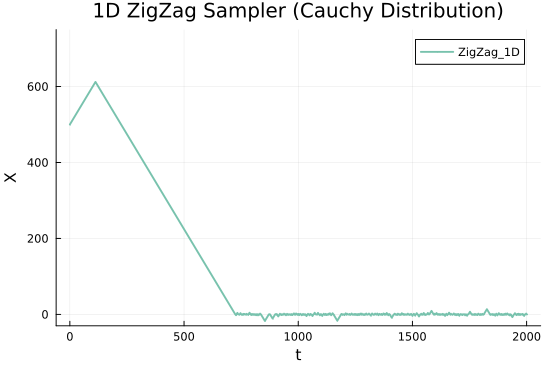

In [10]:
#| code-fold: true
#| echo: false
#| fig-cap: "\rC(0,1) に対する ZigZag サンプラーの軌道"
using ZigZagBoomerang
using LinearAlgebra
using SparseArrays
using Plots
using RandomNumbers.Xorshifts

rng = Xoroshiro128Plus(2022)

# C(0,1) 分布のポテンシャル関数（使わない）
U(x) = log(1 + x^2)

# ポテンシャル関数の勾配
∇U(x) = 2x / (1 + x^2)

# 初期値
x0 = 500.0
θ0 = 1.0

T = 2000.0  # 総シミュレーション時間

# ZigZag過程の設定
Z = ZigZag1d()

# リジェクションバウンド（必要に応じて調整）
c = 1.0

k = 1.0

# ZigZag過程の実行
trace, acc = ss_pdmp(∇U, x0, θ0, T, c, k, Z; rng=rng)

# 軌跡の離散化とサンプリング
# dt = 0.1
# traj = collect(ZigZagBoomerang.discretize(trace, dt))

traj = [(x[1], x[2]) for x in trace]

# サンプルの表示

plot_1dtraj(traj, title="1D ZigZag Sampler (Cauchy Distribution)", markersize=0, ylim=(-30, 750), label="ZigZag_1D")

Sampling:  80%|████████████████████████████████▋        |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


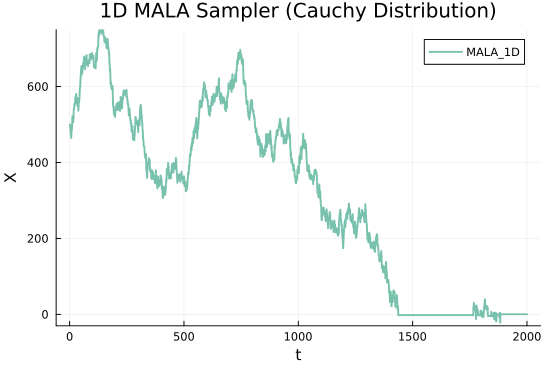

In [11]:
#| code-fold: true
#| fig-cap: "\rC(0,1) に対する MALA サンプラーの軌道"
using AdvancedHMC, AdvancedMH, ForwardDiff
using LinearAlgebra
using LogDensityProblems
using LogDensityProblemsAD
using StructArrays
using Distributions
using Random

Random.seed!(2)

# Define the target distribution (1D Cauchy) using the `LogDensityProblem` interface
struct LogTargetDensityCauchy
    loc::Float64
    scale::Float64
end

LogDensityProblems.logdensity(p::LogTargetDensityCauchy, θ) = -log(π) - log(p.scale) - log(1 + ((θ[1] - p.loc)/p.scale)^2)
LogDensityProblems.dimension(p::LogTargetDensityCauchy) = 1
LogDensityProblems.capabilities(::Type{LogTargetDensityCauchy}) = LogDensityProblems.LogDensityOrder{0}()

# Choose initial parameter value for 1D
initial_θ = [500.0]

# Use automatic differentiation to compute gradients
model_with_ad = LogDensityProblemsAD.ADgradient(Val(:ForwardDiff), LogTargetDensityCauchy(0.0, 1.0))

# Set up the sampler with a multivariate Gaussian proposal.
σ² = 100
spl = MALA(x -> MvNormal((σ² / 2) .* x, σ² * I))

# Sample from the posterior.
chain = sample(model_with_ad, spl, 2000; initial_params=initial_θ, chain_type=StructArray, param_names=["θ"])

# plot
θ_vector = chain.θ
sample_values = zip(1:length(θ_vector), θ_vector)
plot_1dtraj(sample_values, title="1D MALA Sampler (Cauchy Distribution)", markersize=0, ylim=(-30, 750), label="MALA_1D")

In [12]:
#| echo: false
#| output: false

# Define the Cauchy distribution with location and scale
loc, scale = 0.0, 1.0
ℓπ = LogTargetDensityCauchy(loc, scale)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 2000, 0

# Define a Hamiltonian system
metric = DiagEuclideanMetric(1)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with the initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = Leapfrog(initial_ϵ)

# Define an HMC sampler with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Cauchy distribution, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples, stats = sample(hamiltonian, kernel, initial_θ, n_samples, adaptor, n_adapts; progress=true)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/gA66f/src/ProgressMeter.jl:590
Sampling 100%|███████████████████████████████| Time: 0:00:00
  iterations:                                   2000
  ratio_divergent_transitions:                  0.02
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      1
  is_accept:                                    true
  acceptance_rate:                              2.863469784959107e-17
  log_density:                                  -15.86419320804587
  hamiltonian_energy:                           15.864286021695538
  hamiltonian_energy_error:                     0.0
  max_hamiltonian_energy_e

┌ Info: Finished 2000 sampling steps for 1 chains in 0.535522958 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=1640.0), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 0.3245110367226575
└   average_acceptance_rate = 0.2537609789148177


([[500.0], [500.0], [-1490.9425976095117], [1239.660000937718], [1419.1057953677991], [1952.9704516433658], [1952.9704516433658], [-413.3050126275907], [-413.3050126275907], [-413.3050126275907]  …  [-1046.117968392255], [19260.19698383325], [7526.906939043931], [2509.1642162114567], [2509.1642162114567], [2976.1795637021214], [1752.1425652670162], [-1571.4145164616164], [-1571.4145164616164], [-1571.4145164616164]], NamedTuple[(n_steps = 1, is_accept = true, acceptance_rate = 0.0026437363189432904, log_density = -13.573950082685784, hamiltonian_energy = 13.83908561450436, hamiltonian_energy_error = 0.0, max_hamiltonian_energy_error = 5.935562090050862, tree_depth = 1, numerical_error = false, step_size = 1638.4, nom_step_size = 1638.4, is_adapt = false), (n_steps = 1, is_accept = true, acceptance_rate = 0.00027882999271169586, log_density = -13.573950082685784, hamiltonian_energy = 13.589073219813551, hamiltonian_energy_error = 0.0, max_hamiltonian_energy_error = 8.184908306988467, tr

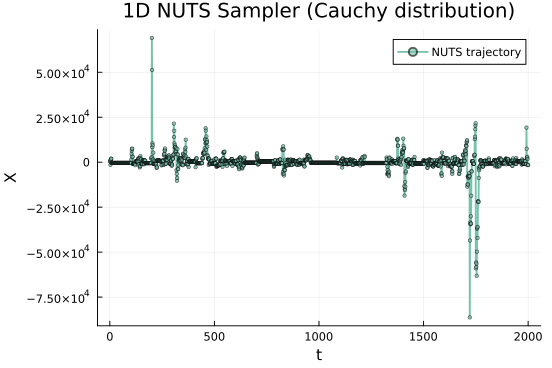

In [13]:
#| echo: false
#| fig-cap: "\rC(0,1) に対する NUTS サンプラーの軌道"
using Plots

sample_values = [s[1] for s in samples]
p = plot(1:length(samples), sample_values,
             label="NUTS trajectory",
             title="1D NUTS Sampler (Cauchy distribution)",
             xlabel="t",
             ylabel="X",
             linewidth=2,
             marker=:circle,
             markersize=2,
             markeralpha=0.6,
             color="#78C2AD")

In [14]:
using ZigZagBoomerang
using SparseArrays

d = 2

# 対数尤度関数 ϕ の第 i 成分に関する微分を計算
Γ = sparse([1,1,2,2], [1,2,1,2], [2.0,-1.0,-1.0,2.0])  # <1>
∇ϕ(x, i, Γ) = ZigZagBoomerang.idot(Γ, i, x)  # <2>

# 初期値
t0 = 0.0
x0 = randn(d)
θ0 = rand([-1.0,1.0], d)

# Rejection bounds
c = 1.0 * ones(length(x0))

# ZigZag 過程をインスタンス化
Z = ZigZag(Γ, x0*0)

# シミュレーション実行
T = 20.0
@time zigzag_trace, (tT, xT, θT), (acc, num) = spdmp(∇ϕ, t0, x0, θ0, T, c, Z, Γ; adapt=true)

# 軌跡を離散化
@time traj = collect(discretize(zigzag_trace, 0.1))

# 結果の表示
println("Final state: ", xT)
println("Trajectory length: ", length(traj))

  0.327210 seconds (1.13 M allocations: 75.180 MiB, 3.97% gc time, 99.86% compilation time)
  0.034764 seconds (121.00 k allocations: 8.171 MiB, 99.88% compilation time)
Final state: 

[-0.04853823604474994, 0.5167936032933929]
Trajectory length: 204


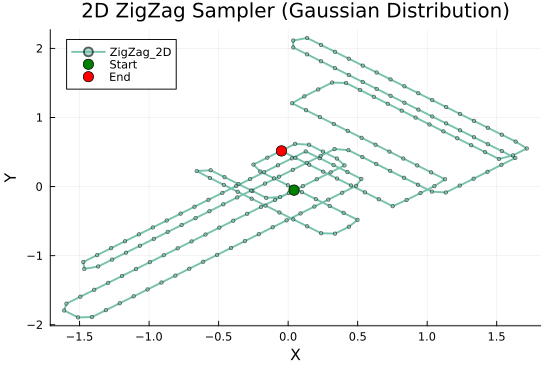

In [15]:
#| echo: false

plot_2dtraj(traj, title="2D ZigZag Sampler (Gaussian Distribution)")